In [174]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy

import matplotlib.animation as animation
import IPython

import torch.distributions as tdist

from ipywidgets import interact

$\newcommand{\elbo}{\mathrm{ELBO}}$
$\newcommand{\kl}{\mathrm{KL}}$
$\newcommand{\set}[1]{ \left\{ #1 \right\}}$
$\def\R{{\mathbb R}}$
$\def\Q{{\mathbb Q}}$
$\def\E{{\mathbb E}}$
$\def\C{{\mathbb C}}$
$\def\N{{\mathbb N}}$
$\def\Z{{\mathbb Z}}$

$\newcommand{\brac}[1]{\left(#1\right)}$
$\newcommand{\abs}[1]{\left|\, #1\,\right|}$
$\newcommand{\p}{\partial}$
$\newcommand{\abrac}[1]{\left\langle #1 \right\rangle}$
$\newcommand{\sqbrac}[1]{\left[ #1 \right]}$
$\newcommand{\st}{\, \, : \,}$
$\newcommand{\supp}{\mathrm{supp}}$
$\newcommand{\norm}[1]{\lVert #1 \rVert}$
$\renewcommand{\d}[1]{\, \mathrm{d}#1 \,}$

# Unit tests (Making sure that code works as intended)

## Unit test 1: Gaussian family VI to learn known Gaussian posterior
Will try to do variational inference against toy Gaussian posterior to make sure that the code has intended behaviour. 

We will attempt to approximate the normal distribution 
$$
p(\xi) = \frac{1}{(2\pi)^{d/2} \sqrt{\mathrm{det}(\sigma_0^2I_d)}} e^{\frac{1}{2\sigma_0^2}\sum_{j = 1}^d (\xi_j - \mu_{0j})^2}. 
$$

We shall find a distribution from the following Gaussian family
$$
\mathcal{Q}_{gaussian} = \set{q_{\mu, \sigma}(\xi) = \frac{1}{(2\pi)^{d/2} \sqrt{\mathrm{det}(\sigma^2I_d)}} e^{\frac{1}{2\sigma^2}\sum_{j = 1}^d (\xi_j - \mu_{j})^2} \st \mu \in \R^d, \sigma \in \R_{> 0}}
$$


In this case, we have ELBO given by 
$$
-\elbo(q) = \E_q\sqbrac{\log \frac{q(\xi)}{e^{-\frac{1}{2\sigma_0^2}\sum_j (\xi_j - \mu_{0j})^2}}} = \E_q \log q(\xi) + \frac{1}{2\sigma_0^2} \E_q \sum_j (\xi_j - \mu_{0j})^2
$$

Epoch     0: mu=tensor([0.1000, 0.9000]), sigma=0.900, elbo=-1.22
Epoch 10000: mu=tensor([0.1400, 0.8700]), sigma=0.380, elbo=-0.19
Epoch 20000: mu=tensor([0.2300, 0.7700]), sigma=0.197, elbo=-0.85
Epoch 30000: mu=tensor([0.3700, 0.6400]), sigma=0.254, elbo=-0.25
Epoch 40000: mu=tensor([0.5300, 0.4800]), sigma=0.639, elbo=0.30
Epoch 50000: mu=tensor([0.6800, 0.3200]), sigma=0.823, elbo=-0.35
Epoch 60000: mu=tensor([0.8100, 0.1900]), sigma=0.327, elbo=-0.21
Epoch 70000: mu=tensor([0.8800, 0.1100]), sigma=0.189, elbo=-1.24
Epoch 80000: mu=tensor([0.8800, 0.0900]), sigma=0.281, elbo=-0.66
Epoch 90000: mu=tensor([0.8400, 0.1500]), sigma=0.784, elbo=-0.62
Epoch 100000: mu=tensor([0.7300, 0.2700]), sigma=0.596, elbo=0.17
Epoch 110000: mu=tensor([0.5900, 0.4300]), sigma=0.237, elbo=-0.31
Epoch 120000: mu=tensor([0.4200, 0.6100]), sigma=0.196, elbo=-0.59
Epoch 130000: mu=tensor([0.2800, 0.7600]), sigma=0.379, elbo=0.10
Epoch 140000: mu=tensor([0.1700, 0.8700]), sigma=0.881, elbo=-0.95
Epoch 15

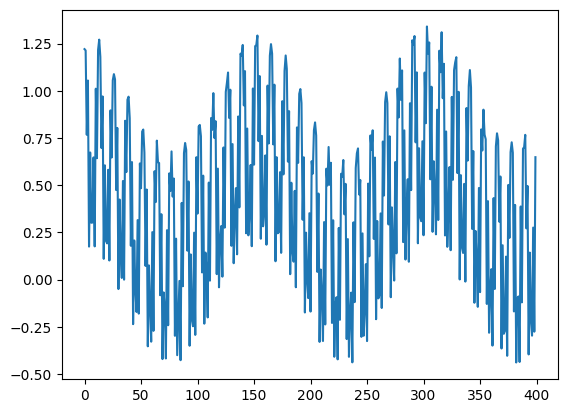

In [175]:
mu_0 = torch.tensor([0.5, 0.5])
sigma_0 = torch.tensor([0.5])

mu = nn.Parameter(torch.tensor([.1, .9], dtype=torch.float))
logsigma = nn.Parameter(torch.tensor([np.log(0.9)], dtype=torch.float))
lr = 0.00001
optim = torch.optim.SGD([mu, logsigma], lr=lr)
num_epoch = 200000
S = 2000
num_snapshots = 200
snapshots = []
rec = []
for epoch in range(num_epoch):
    q = tdist.MultivariateNormal(loc=mu, covariance_matrix=torch.eye(2) * torch.exp(2 * logsigma))
    xi = q.rsample((S, ))
    term1 = q.log_prob(xi)
    term2 = torch.sum((xi - mu_0)**2, dim=1) / (2 * sigma_0**2)
    neg_elbo = torch.mean(term1 + term2)
    neg_elbo.backward()
    optim.step()
    
    if epoch % (num_epoch // num_snapshots) == 0:
        snapshots.append([epoch, mu.clone().detach(), logsigma.clone().detach(), -neg_elbo.detach()])
    
    if epoch % 500 == 0:
        rec.append(neg_elbo.detach())
    
    if epoch % (num_epoch // 20) == 0:
        print(
            f"Epoch {epoch:5d}: mu={np.around(mu.detach(), 2)}, "
            f"sigma={torch.exp(logsigma).item():.3f}, elbo={-neg_elbo:.2f}"
        )

plt.plot(rec)

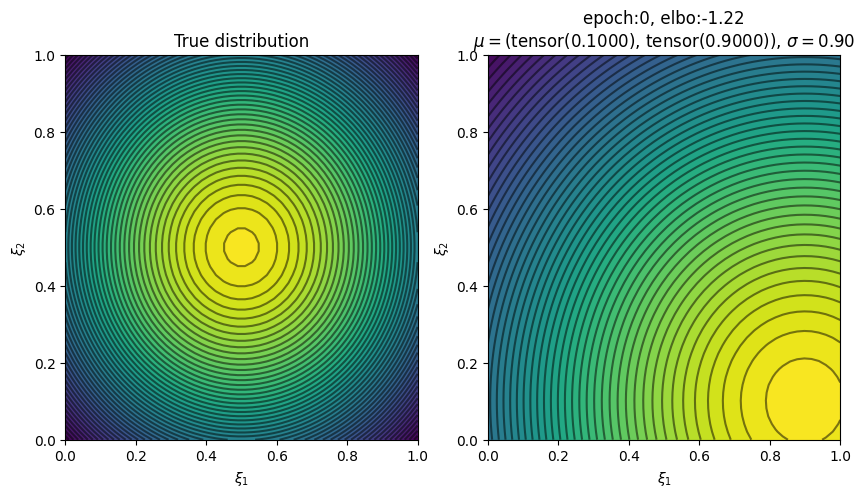

In [176]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
N = 50
levels = 50
xx, yy = np.meshgrid(np.linspace(0, 1, num=N), np.linspace(0, 1, num=N))

ax = axes[0]
q = tdist.MultivariateNormal(loc=mu_0, covariance_matrix=torch.eye(2) * sigma_0)
z = np.exp(q.log_prob(torch.tensor(np.stack([xx, yy])).T))
ax.contourf(xx, yy, z, levels=levels)
ax.contour(xx, yy, z, levels=levels, colors='k', alpha=0.5)
ax.set_xlabel("$\\xi_1$")
ax.set_ylabel("$\\xi_2$")
ax.set_title("True distribution")

ax = axes[1]
epoch, mu, logsigma, elbo = snapshots[0]
q = tdist.MultivariateNormal(loc=mu, covariance_matrix=torch.eye(2) * torch.exp(2 * logsigma))
z = np.exp(q.log_prob(torch.tensor(np.stack([xx, yy])).T))
contourf = ax.contourf(xx, yy, z, levels=levels)
contour = ax.contour(xx, yy, z, levels=levels, colors='k', alpha=0.5)
ax.set_xlabel("$\\xi_1$")
ax.set_ylabel("$\\xi_2$")
ax.set_title("True distribution")


def animate(frame_num):
    global ax, contour, contourf
    epoch, mu, logsigma, elbo = snapshots[frame_num]
    q = tdist.MultivariateNormal(loc=mu, covariance_matrix=torch.eye(2) * torch.exp(2 * logsigma))
    z = np.exp(q.log_prob(torch.tensor(np.stack([xx, yy])).T))
    
    for col in contourf.collections:
        col.remove()
    contourf = ax.contourf(xx, yy, z, levels=levels)
    ax.set_title(f"epoch:{epoch}, elbo:{elbo:.2f}\n$\\mu=${(mu[0], mu[1])}, $\\sigma=${torch.exp(logsigma).item():.2f}")
    
    for col in contour.collections:
        col.remove()
    contour = ax.contour(xx, yy, z, levels=levels, colors='k', alpha=0.5)
    return contour, contourf

anim = animation.FuncAnimation(fig, animate, frames=len(snapshots), interval=300)
video = anim.to_html5_video()
IPython.display.display(IPython.display.HTML(video))


## Unit test 2: Mean field generalised gamma family to learn mean field generalised gamma

Here we try to use a mean-field generalised gamma family to learn a known generalised gamma distribution: 
$$
p(\xi) = \prod_{j = 1}^2 \frac{\beta_{0j}^{\lambda_{0j}}}{\Gamma(\lambda_{0j})} \xi_j^{2k_{0j}\lambda_{0j} - 1} e^{-\beta_{0j}\xi_j^{2k_{0j}}}
$$

The mean-field generalised gamma variational family is given by
$$
\mathcal{Q}_{gamma} := \set{
q_{\theta}(\xi) = \prod_{j = 1}^2 \frac{2k_j\beta_j^{\lambda_j}}{\gamma(\lambda_j, \beta_j)\Gamma(\lambda)} \xi_j^{2k_j \lambda_j -1} e^{-\beta_j \xi_j^{2k_j}} \st \theta = (\lambda_1, \lambda_2, k_1, k_2, \beta_1, \beta_2) \in \R^{3d}_{\geq 0}}
$$

In this case, we have ELBO given by 
$$
-\elbo(q) = \E_q\sqbrac{\log \frac{q(\xi)}{\prod_{j = 1}^2 \xi_j^{2k_j \lambda_j -1} e^{-\beta_j \xi_j^{2k_j}} }} = \E_q \log q(\xi) + \frac{1}{2\sigma_0^2} \E_q \sum_j (\xi_j - \mu_{0j})^2
$$

# Experiment 1: Learning 2D standard form posterior 

## Experiment 1.0: Learning with Gaussian Family

We are assuming that our posterior is of the form 
$$
p(\xi_1, \xi_2) = \frac{1}{\overline{Z}_n} \xi_1^{h_1} \xi_2^{h_2} e^{-n \xi_1^{2k_1} \xi_2^{2k_2}}, \quad (\xi_1, \xi_2) \in [0, 1]^2
$$
where $\overline{Z}_n = \int_{[0, 1]^2} \xi_1^{h_1} \xi_2^{h_2} e^{-n \xi_1^{2k_1} \xi_2^{2k_2}} d\xi_1 d\xi_2$ is the normalising constant, a.k.a. the evidence.  

The posterior contours would look like the following:

In [9]:
N = 200
xx, yy = np.meshgrid(np.linspace(0, 1, num=N), np.linspace(0, 1, num=N))


@interact(
    n=(2, 10000),
    k1=(0, 5),
    k2=(0, 5),
    h1=(0, 5),
    h2=(0, 5)
)
def _plot_contour(n=500, k1=2, k2=3, h1=1, h2=2):
    fig, ax = plt.subplots(1, 1, figsize=(5, 5))
    z = np.abs((xx ** h1) * (yy ** h2)) * np.exp(-n * (xx **(2 * k1)) * (yy **(2*k2)))
    normalising_const = np.sum(z) / (N**2)
    
    lambdas = np.array([(h1 + 1) / (2 * k1), (h2 + 1) / (2 * k2)])
    rlct = np.min(lambdas)
    m = np.sum(lambdas == rlct)
    const_term = (
        scipy.special.loggamma(rlct) 
        - np.log(scipy.special.factorial(m -1)) 
        - np.log(2 * k1) - np.log(2 * k2)
    )
    ks = [k1, k2]
    hs = [h1, h2]
    j = np.argmax(lambdas)
    if m == 1:
        const_term -= np.log(-2 * rlct * ks[j] + hs[j] + 1)
    print(
        f"-logZ = {-np.log(normalising_const)}\n"
        f"RLCT  = {rlct}\n"
        f"m     = {m}\n"
        f"const = {const_term}\n"
        f"rlct log(n) - (m - 1) log log n = {rlct * np.log(n) - (m -1) * np.log(np.log(n))}"
    )
    ax.contourf(xx, yy, z / normalising_const, levels=100)
    ax.set_xlabel("$\\xi_1$")
    ax.set_ylabel("$\\xi_2$")

interactive(children=(IntSlider(value=500, description='n', max=10000, min=2), IntSlider(value=2, description=…

Given a variational family $\mathcal{Q}$, we wish to find a variational approximation $\hat{q} \in \mathcal{Q}$ that minimises the KL-divergence $KL(\hat{q} || p(\xi_1, \xi_2)$. Notice though that this is equivalent to maximising the ELBO = Evidence Lower Bound: 
$$
\elbo(q)= -\E_q\sqbrac{n\xi^{2k}} - \E_q \log \frac{q(\xi)}{\xi^h} \\
$$

This can be shown by the following calculation. 
$$
\begin{align*}
  \kl(q||p) 
  &= \E_q\log \frac{q(\xi)}{p(\xi)}\\
  &= \log \overline{Z}_n + \E_q\log \frac{q(\xi)}{\xi_1^{h_1} \xi_2^{h_2} e^{-n \xi_1^{2k_1} \xi_2^{2k_2}}} \\
  &= \log \overline{Z}_n + \E_q\log \frac{q(\xi)}{\xi_1^{h_1} \xi_2^{h_2}} + \E_q n \xi_1^{2k_1} \xi_2^{2k_2}\\
\end{align*}
$$
Since $\kl(q||p) \geq 0$, we can bound the log-evidence with 
$$
  \log \overline{Z}_n \geq -\E_q\log \frac{q(\xi)}{\xi_1^{h_1} \xi_2^{h_2}} - \E_q n \xi_1^{2k_1} \xi_2^{2k_2} =: \elbo(q)
$$

## Gaussian Variational Family
We shall first use a simple Gaussian family of distribution for variational inference. 
$$
\mathcal{Q}_{gaussian} := \set{q_{\mu_1, \mu_2, \sigma}(\xi) = \frac{1}{2\pi \sigma^2} e^{-\frac{1}{2\sigma^2} \sqbrac{(\xi_1 - \mu_1)^2 + (\xi_2 - \mu_2)^2}} \st \mu_1, \mu_2 \in \R, \sigma \in (0, \infty)}
$$

To maximise $\elbo(q)$ for $q \in \mathcal{Q}_{gaussian}$ via gradient descent on the variational parameters $\theta = (\mu_1, \mu_2, \sigma)$, we need unbiased estimate for the gradient $\nabla_{\theta} \elbo(q)$. We can apply the reparametrisation trick to the above gaussian family as follow, for each $j = 1, 2$
 1. We sample noise $\epsilon_j$ independently from $N(0, 1)$. 
 2. Set $\xi_j = \mu_j + \sigma \epsilon_j$. 

This construction implies that $\xi_j \sim N(\mu_j, \sigma^2)$ and $(\xi_1, \xi_2) \sim q_\theta$. We can then estimate the gradient of ELBO as
$$
\begin{align*}
  -\nabla_\theta \elbo(q_\theta) 
  &= \nabla_\theta \E_q\log \frac{q(\xi)}{\xi_1^{h_1} \xi_2^{h_2}} + \E_q n \xi_1^{2k_1} \xi_2^{2k_2}\\
  &= \nabla_\theta \E_q\log q(\xi) -  \E_q \log(\xi_1^{h_1} \xi_2^{h_2}) + \E_q n \xi_1^{2k_1} \xi_2^{2k_2}
\end{align*}
$$

0: mu=tensor([0.1000, 0.9000]), sigma=0.300, elbo=-25.42
5000: mu=tensor([0.4500, 0.3100]), sigma=0.167, elbo=-4.68
10000: mu=tensor([ 0.9700, -0.2000]), sigma=0.102, elbo=-5.58
15000: mu=tensor([ 1.0400, -0.1900]), sigma=0.061, elbo=-6.25
20000: mu=tensor([0.5800, 0.3000]), sigma=0.039, elbo=-6.72
25000: mu=tensor([0.1400, 0.8100]), sigma=0.024, elbo=-7.14
30000: mu=tensor([0.0700, 1.3100]), sigma=0.015, elbo=-7.78
35000: mu=tensor([0.0500, 1.8100]), sigma=0.009, elbo=-8.48
40000: mu=tensor([0.0500, 2.3100]), sigma=0.006, elbo=-9.38
45000: mu=tensor([0.0500, 2.8100]), sigma=0.004, elbo=-10.76
50000: mu=tensor([0.0100, 3.3000]), sigma=0.004, elbo=-10.89
55000: mu=tensor([-0.0100,  3.8000]), sigma=0.007, elbo=-9.01
60000: mu=tensor([-0.0100,  4.2900]), sigma=0.013, elbo=-8.36
65000: mu=tensor([0.0100, 4.7900]), sigma=0.016, elbo=-9.21
70000: mu=tensor([0.0200, 5.2800]), sigma=0.009, elbo=-14.30
75000: mu=tensor([-0.0200,  5.7600]), sigma=0.005, elbo=-16.75
80000: mu=tensor([0.0000, 6.22

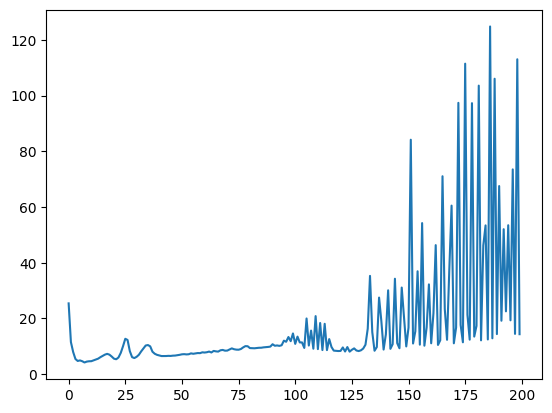

In [10]:
n = 500
k = torch.tensor([2, 3])
h = torch.tensor([1, 2])

mu = nn.Parameter(torch.tensor([.1, .9], dtype=torch.float))
logsigma = nn.Parameter(torch.tensor([np.log(0.3)], dtype=torch.float))
lr = 0.0001
optim = torch.optim.Adam([mu, logsigma], lr=lr)
num_epoch = 100000
S = 1000
num_snapshots = 200
snapshots = []
rec = []
for epoch in range(num_epoch):
    q = tdist.MultivariateNormal(loc=mu, covariance_matrix=torch.eye(2) * torch.exp(2 * logsigma))
    xi = q.rsample((S, ))
    
    term1 = q.log_prob(xi)
    term2 = torch.sum(torch.log(torch.abs(xi)) * h, dim=1)
    term3 = n * torch.prod(xi**(2 * k), dim=1)
    neg_elbo = torch.mean(term1 - term2 + term3)
    neg_elbo.backward()
    optim.step()
    
    if epoch % (num_epoch // num_snapshots) == 0:
        snapshots.append([epoch, mu.clone().detach(), logsigma.clone().detach(), -neg_elbo.detach()])
    
    if epoch % 500 == 0:
        rec.append(neg_elbo.detach())
    
    if epoch % (num_epoch // 20) == 0:
        print(
            f"{epoch}: mu={np.around(mu.detach(), 2)}, "
            f"sigma={torch.exp(logsigma).item():.3f}, elbo={-neg_elbo:.2f}"
        )
plt.plot(rec)


/var/folders/g1/hm_8np0d0yvdjls6yf0mht5r0000gp/T/ipykernel_18997/1264161546.py:43: UserWarning: No contour levels were found within the data range.
  contour = ax.contour(xx, yy, z, levels=levels, colors='k', alpha=0.5)


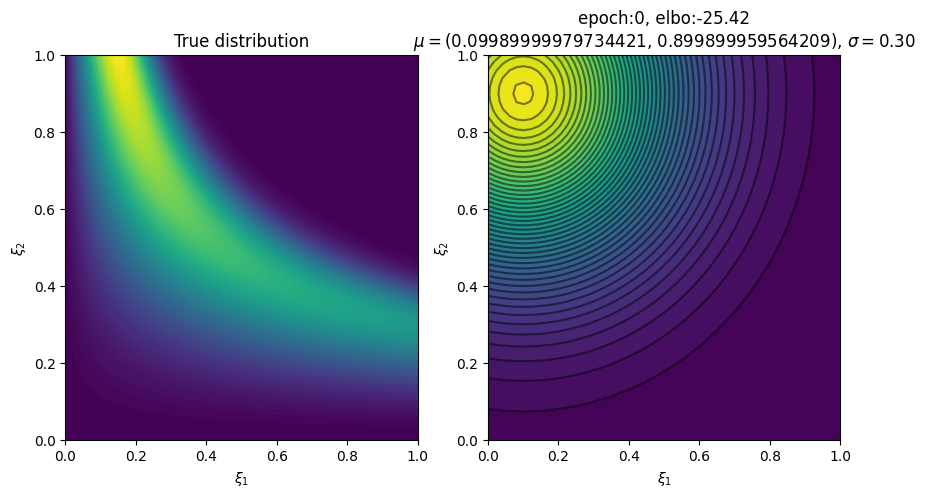

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
N = 50
levels = 50
xx, yy = np.meshgrid(np.linspace(0, 1, num=N), np.linspace(0, 1, num=N))

ax = axes[0]
k1, k2 = k.numpy()
h1, h2 = h.numpy()
z = np.abs((xx ** h1) * (yy ** h2)) * np.exp(-n * (xx **(2 * k1)) * (yy **(2*k2)))
normalising_const = np.sum(z) / (N**2)
ax.contourf(xx, yy, z / normalising_const, levels=100)
ax.set_xlabel("$\\xi_1$")
ax.set_ylabel("$\\xi_2$")
ax.set_title("True distribution")

ax = axes[1]
epoch, mu, logsigma, elbo = snapshots[0]
sigma = torch.exp(logsigma)
q = tdist.MultivariateNormal(mu, torch.eye(2) * (sigma**2))
z = q.log_prob(torch.tensor(np.stack((xx, yy), axis=-1)))
z = torch.exp(z)
contourf = ax.contourf(xx, yy, z, levels=levels)
contour = ax.contour(xx, yy, z, levels=levels, colors='k', alpha=0.5)
ax.set_xlabel("$\\xi_1$")
ax.set_ylabel("$\\xi_2$")

def animate(frame_num):
    global ax, contour, contourf
    epoch, mu, logsigma, elbo = snapshots[frame_num]
    q = tdist.MultivariateNormal(loc=mu, covariance_matrix=torch.eye(2) * torch.exp(2 * logsigma))
    z = np.exp(q.log_prob(torch.tensor(np.stack([xx, yy], axis=-1))))
    
    for col in contourf.collections:
        col.remove()
    contourf = ax.contourf(xx, yy, z, levels=levels)
    ax.set_title(
        f"epoch:{epoch}, elbo:{elbo:.2f}\n"
        f"$\\mu=${(mu[0].item(), mu[1].item())}, $\\sigma=${torch.exp(logsigma).item():.2f}"
    )
    
    for col in contour.collections:
        col.remove()
    contour = ax.contour(xx, yy, z, levels=levels, colors='k', alpha=0.5)
    return contour, contourf

anim = animation.FuncAnimation(fig, animate, frames=len(snapshots), interval=300)
video = anim.to_html5_video()
IPython.display.display(IPython.display.HTML(video))

# Experiment 2: Learning 2D standard form with Gamma Mean Field Family

## Generalised Gamma Mean Field Family
Our variational family in this case is a mean field family of generalised gamma distributions.
$$
\mathcal{Q}_{gamma} := \set{
q_{\theta}(\xi) = \prod_{j = 1}^2 \frac{2k_j\beta_j^{\lambda_j}}{\Gamma(\lambda)} \xi_j^{2k_j \lambda_j -1} e^{-\beta_j \xi_j^{2k_j}} \st \theta = (\lambda_1, \lambda_2, k_1, k_2, \beta_1, \beta_2) \in \R^{3d}_{\geq 0}, \xi \in [0, \infty)}
$$

To maximise $\elbo(q)$ for $q \in \mathcal{Q}_{gaussian}$ via gradient descent on the variational parameters $\theta = (\mu_1, \mu_2, \sigma)$, we need unbiased estimate for the gradient $\nabla_{\theta} \elbo(q)$. We can apply the reparametrisation trick to the above gaussian family as follow, for each $j = 1, 2$
 1. We sample noise $\epsilon_j$ independently from $N(0, 1)$. 
 2. Set $\xi_j = \mu_j + \sigma \epsilon_j$. 

This construction implies that $\xi_j \sim N(\mu_j, \sigma^2)$ and $(\xi_1, \xi_2) \sim q_\theta$. We can then estimate the gradient of ELBO as
$$
\begin{align*}
  - \elbo(q_\theta) 
  &= \E_q n \xi_1^{2k_{01}} \xi_2^{2k_{02}} + \E_q\log \frac{q(\xi)}{\xi_1^{h_{01}} \xi_2^{h_{02}}}\\
\end{align*}
$$

The first term is given by (with $d = 2$ below)
$$
\begin{align*}
\E_q n \xi_1^{2k_1} \xi_2^{2k_2}
&= n \prod_{j = 1}^d \int_0^\infty q_j(\xi_j) \xi_j^{2k_{0j}} d\xi_j\\
&= n \prod_{j = 1}^d \frac{2k_j\beta_j^{\lambda_j}}{\Gamma(\lambda_j)} \int_0^\infty \xi_j^{2k_j \lambda_j -2k_{0j} -1} e^{-\beta_j \xi_j^{2k_j}} d\xi_j \\
&= n \prod_{j = 1}^d \frac{2k_j\beta_j^{\lambda_j}}{\Gamma(\lambda_j)} \frac{1}{2k_j\beta_j^{\lambda_j + \frac{k_{0j}}{k_j}}}\Gamma\brac{\lambda_j + \frac{k_{0j}}{k_j}}\\
&= n \prod_{j = 1}^d \frac{1}{ \beta_j^{k_{0j} / k_j}}\frac{\Gamma\brac{\lambda_j + \frac{k_{0j}}{k_j}}}{\Gamma(\lambda_j)}
\end{align*}
$$

The second term is given by 
$$
\begin{align*}
\E_q\log \frac{q(\xi)}{\xi_1^{h_1} \xi_2^{h_2}}
&= \sum_{j = 1}^d \int_0^\infty q_j(\xi_j) \log \frac{q(\xi_j)}{\xi_j^{2\lambda_{0j} k_{0j} -1}}d\xi_j\\
&= \sum_{j = 1}^d \int_0^\infty q_j(\xi_j) \log \frac{\frac{2k_j\beta_j^{\lambda_j}}{\Gamma(\lambda)} \xi_j^{2k_j \lambda_j -1} e^{-\beta_j \xi_j^{2k_j}}}{\xi_j^{2\lambda_{0j} k_{0j} -1}}d\xi_j\\
&= \sum_{j = 1}^d \log\brac{\frac{2k_j\beta_j^{\lambda_j}}{\Gamma(\lambda)} } 
- \beta_j \int_0^\infty q(\xi_j) \xi_j^{2k_j} d\xi_j
+ \brac{2k_j \lambda_j - 2k_{0j}\lambda_{0j}}\int_0^\infty q_j(\xi_j) \log \xi_j d\xi_j\\
&=  \sum_{j = 1}^d 
\log(2k_j) + \lambda_j\log \beta_j - \log \Gamma(\lambda)
- \beta_j \frac{\beta_j^{\lambda_j}2k_j}{\Gamma(\lambda_j)} \frac{\Gamma(\lambda_j + 1)}{2k_j \beta_j^{\lambda_j + 1}}
+ \brac{2k_j \lambda_j - 2k_{0j}\lambda_{0j}}\int_0^\infty q_j(\xi_j) \log \xi_j d\xi_j\\
&=  \sum_{j = 1}^d 
\log(2k_j) + \lambda_j\log \beta_j - \log \Gamma(\lambda)
- \lambda_j
+ \brac{2k_j \lambda_j - 2k_{0j}\lambda_{0j}}\frac{1}{2k_j}\brac{\psi(\lambda_j) - \log \beta_j}\\
&=  \sum_{j = 1}^d 
\log(2k_j) + \lambda_j\log \beta_j - \log \Gamma(\lambda)
- \lambda_j
+ \brac{\lambda_j - \frac{k_{0j}}{k_j}\lambda_{0j}}\brac{\psi(\lambda_j) - \log \beta_j}. 
\end{align*}
$$

To evaluate $\E_{q_j}\log \xi_j$, we have use the following observation 
$$
\frac{d}{d\lambda}\Gamma(\lambda) = \int_0^\infty e^{-t} \frac{d}{d\lambda}t^{\lambda -1} dt = \int_0^\infty e^{-t} t^{\lambda -1} \log t dt
$$
and hence, using the substitution $t =\beta \xi^{2k}$
$$
\begin{align*}
\E_{q} \log \xi 
&= \frac{2k\beta^{\lambda}}{\Gamma(\lambda)}\int_0^\infty e^{-\beta \xi^{2k}} \xi^{2\lambda k - 1} \log \xi d\xi\\
&= \frac{2k\beta^{\lambda}}{\Gamma(\lambda)}\int_0^\infty e^{-t} \brac{\frac{t}{\beta}}^{\lambda - 1/(2k)} \log\brac{\frac{t}{\beta}}^{1/(2k)} \frac{t^{1/(2k) - 1}}{2k\beta^{1/(2k)}} dt\\
&= \frac{2k\beta^{\lambda}}{\Gamma(\lambda)}\frac{1}{4k^2 \beta^\lambda}\int_0^\infty e^{-t} t^{\lambda -1} \brac{\log t - \log \beta}dt\\
&= \frac{1}{2k\Gamma(\lambda)}\brac{\int_0^\infty e^{-t} t^{\lambda -1} \log t dt - \log \beta \int_0^\infty e^{-t}t^{\lambda -1} dt}\\
&= \frac{1}{2k\Gamma(\lambda)}\brac{\Gamma'(\lambda) - \Gamma(\lambda)\log \beta }\\
&= \frac{1}{2k}\brac{\frac{\Gamma'(\lambda)}{\Gamma(\lambda)} - \log \beta}\\
&= \frac{1}{2k}\brac{\psi(\lambda) - \log \beta}\\
\end{align*}
$$

In [217]:
def elbo_func(lambdas, ks, betas, lambdas_0, ks_0, n):
    r = ks_0 / ks
    term1 = n * torch.exp(torch.sum(
        -r * torch.log(betas) +  torch.lgamma(lambdas + r) - torch.lgamma(lambdas)
    ))
    term2 = torch.sum(
        torch.log(2 * ks) + lambdas * torch.log(betas) 
        - torch.lgamma(lambdas) - lambdas 
        + (lambdas - r * lambdas_0) * (torch.digamma(lambdas) - torch.log(betas))
    )
    return -term1 - term2

n        = 1000
lambda_0 = tensor([0.3400, 0.8000])
ks_0     = tensor([20,  3])

Epoch     0: elbo=-35.50
lambdas=tensor([1., 1.])
ks     =tensor([1., 4.])
betas  =tensor([100.,   1.])

Epoch 50000: elbo=-6.38
lambdas=tensor([1.3100, 0.7500])
ks     =tensor([12.9700,  5.5100])
betas  =tensor([138.8100,   1.3300])

Epoch 100000: elbo=-7.04
lambdas=tensor([0.1000, 0.0600])
ks     =tensor([34.5200, 65.6100])
betas  =tensor([1701.8101,   16.2700])

Epoch 150000: elbo=-6.83
lambdas=tensor([0.5000, 0.0000])
ks     =tensor([ 25.9400, 774.9400])
betas  =tensor([20631.8906,   198.9000])

Epoch 200000: elbo=-6.54
lambdas=tensor([0.1300, 0.0000])
ks     =tensor([  43.8300, 8858.5596])
betas  =tensor([246260.7969,   2431.3601])

Epoch 250000: elbo=-6.63
lambdas=tensor([0.2300, 0.0000])
ks     =tensor([   48.0300, 46401.4414])
betas  =tensor([2939351.7500,   29076.9609])

Epoch 300000: elbo=-6.46
lambdas=tensor([0.1100, 0.0000])
ks     =tensor([6.2580e+01, 5.8992e+05])
betas  =tensor([35083900.0000

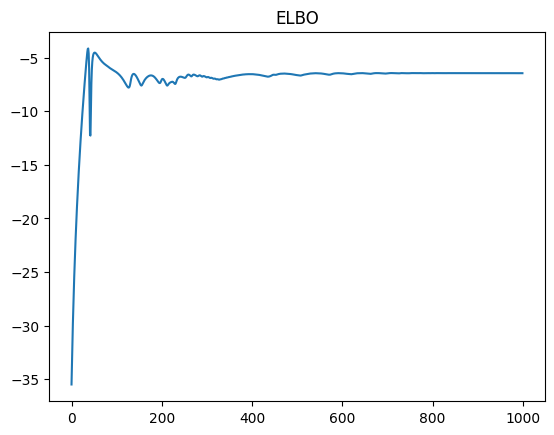

In [254]:
n = 1000
ks_0 = torch.tensor([20, 3])  # assume no "flat" dimensions with k_j = 0
lambdas_0 = torch.tensor([12/35, 16/20])
hs_0 = 2 * ks_0 * lambdas_0 - 1

print(
    f"n        = {n}\n"
    f"lambda_0 = {np.around(lambdas_0.detach(), 2)}\n"
    f"ks_0     = {np.around(ks_0.detach(), 2)}\n"
)

loglambdas = nn.Parameter(torch.log(torch.tensor([1.0, 1.0])))
logbetas = nn.Parameter(torch.log(torch.tensor([100., 1.])))
logks = nn.Parameter(torch.log(torch.tensor([1., 4.])))

lr = 0.00005
optim = torch.optim.Adam([loglambdas, logks, logbetas], lr=lr)
num_epoch = 500000

num_snapshots = 200
snapshots = []
rec = []
max_elbo = -torch.inf
best_params = None
for epoch in range(num_epoch):
    lambdas = torch.exp(loglambdas)
    ks = torch.exp(logks)
    betas = torch.exp(logbetas)
    elbo = elbo_func(lambdas, ks, betas, lambdas_0, ks_0, n)
    neg_elbo = -elbo
    neg_elbo.backward()
    optim.step()
    
    if elbo > max_elbo: 
        max_elbo = elbo
        best_params = {
            "lambdas": lambdas.clone().detach(),
            "ks": ks.clone().detach(),
            "betas": betas.clone().detach()
        }

    if epoch % (num_epoch // num_snapshots) == 0: # epoch > 1000 and -neg_elbo > max_elbo:
        params_rec = {
            "lambdas": lambdas.clone().detach(),
            "ks": ks.clone().detach(),
            "betas": betas.clone().detach()
        }
        snapshots.append([epoch, params_rec, -neg_elbo.detach()])
    
    if epoch % 500 == 0:
        rec.append(-neg_elbo.detach())
    
    if epoch % (num_epoch // 10) == 0:
        print(
            f"Epoch {epoch:5d}: elbo={-neg_elbo:.2f}\n"
            f"lambdas={np.around(lambdas.detach(), 2)}\n"
            f"ks     ={np.around(ks.detach(), 2)}\n"
            f"betas  ={np.around(betas.detach(),2)}\n"
        )

fig, ax = plt.subplots(1,1)
ax.plot(rec)
ax.set_title("ELBO")

print(f"Max elbo: {max_elbo}")
print(f"Best params: {best_params}")

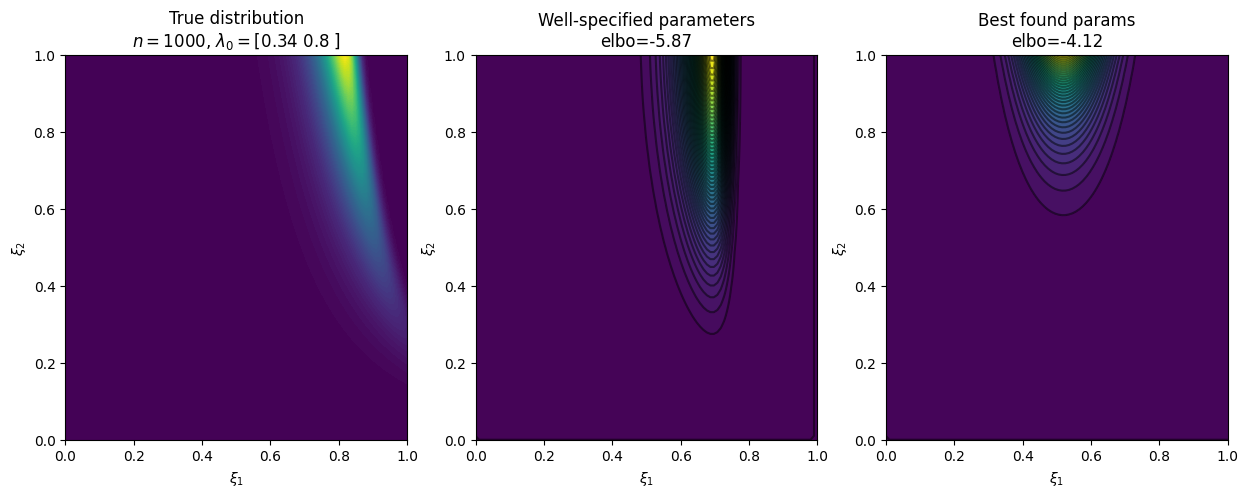

In [259]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
N = 100
levels = 50
a, b = 0, 1
xx, yy = np.meshgrid(np.linspace(a, b, num=N), np.linspace(a, b, num=N))

ax = axes[0]
k1, k2 = ks_0.numpy()
h1, h2 = hs_0.numpy()
z = np.abs((xx ** h1) * (yy ** h2)) * np.exp(-n * (xx **(2 * k1)) * (yy **(2*k2)))
normalising_const = np.sum(z) / (N**2)
ax.contourf(xx, yy, z / normalising_const, levels=100)
ax.set_xlabel("$\\xi_1$")
ax.set_ylabel("$\\xi_2$")
ax.set_title(f"True distribution\n$n=${n}, $\\lambda_0=${str(np.around(lambdas_0.numpy(), 2))}")


ax = axes[1]
lambdas = lambdas_0.numpy()
ks = ks_0.numpy()
betas = np.array([n, 1])
X = np.stack((xx, yy), axis=-1)
z = X ** (2 * ks * lambdas - 1) * np.exp(-betas * (X**ks))
normalising_const = scipy.special.gamma(lambdas) / ( 2 * ks * (betas ** (lambdas)))
z = np.prod(z / normalising_const, axis=-1)

contourf = ax.contourf(xx, yy, z, levels=levels)
contour = ax.contour(xx, yy, z, levels=levels, colors='k', alpha=0.5)
ax.set_xlabel("$\\xi_1$")
ax.set_ylabel("$\\xi_2$")
elbo = elbo_func(lambdas_0, ks_0, torch.tensor(betas), lambdas_0, ks_0, n).detach().numpy()
elbo = str(np.around(elbo, decimals=2))
ax.set_title(f"Well-specified parameters\nelbo={elbo}");


ax = axes[2]
lambdas = best_params["lambdas"].numpy()
ks = best_params["ks"].numpy()
betas = best_params["betas"].numpy()
z = X ** (2 * ks * lambdas - 1) * np.exp(-betas * (X**ks))
normalising_const = scipy.special.gamma(lambdas) / ( 2 * ks * (betas ** (lambdas)))
z = np.prod(z / normalising_const, axis=-1)

contourf = ax.contourf(xx, yy, z, levels=levels)
contour = ax.contour(xx, yy, z, levels=levels, colors='k', alpha=0.5)
ax.set_xlabel("$\\xi_1$")
ax.set_ylabel("$\\xi_2$")
elbo = elbo_func(torch.tensor(lambdas), torch.tensor(ks), torch.tensor(betas), lambdas_0, ks_0, n).detach().numpy()
elbo = str(np.around(elbo, decimals=2))
ax.set_title(f"Best found params\nelbo={elbo}");


In [260]:
def animate(frame_num):
    global ax, contour, contourf, xx, yy, snapshots
    epoch, param_rec, elbo = snapshots[frame_num]
    lambdas = param_rec["lambdas"].numpy()
    ks = param_rec["ks"].numpy()
    betas = param_rec["betas"].numpy()
    X = np.stack((xx, yy), axis=-1)
#     X = np.abs(X)
    z = X ** (2 * ks * lambdas - 1) * np.exp(-betas * (X**ks))
    normalising_const = scipy.special.gamma(lambdas) / ( 2 * ks * betas ** (lambdas))
    z = np.prod(z / normalising_const, axis=-1)

    for col in contourf.collections:
        col.remove()
    contourf = ax.contourf(xx, yy, z, levels=levels)
    ax.set_title(
        f"epoch:{epoch}, elbo:{elbo:.2f}\n"
        f"$\\lambda=${str(np.around(lambdas, 2))}, "
        f"$k=${str(np.around(ks, 2))}, "
        f"$\\beta=${str(np.around(betas,2))}"
    )
    
    for col in contour.collections:
        col.remove()
    contour = ax.contour(xx, yy, z, levels=levels, colors='k', alpha=0.5)
    return contour, contourf

anim = animation.FuncAnimation(fig, animate, frames=range(0, len(snapshots), len(snapshots) // 200 + 1), interval=200)
video = anim.to_html5_video()
IPython.display.display(IPython.display.HTML(video))

In [253]:
%%time 
# anim.save(f"./gamma-mean-field-n={n}.mp4")

CPU times: user 36.4 s, sys: 316 ms, total: 36.7 s
Wall time: 37 s


# Experiment 3: Learning 2D standard form with Truncated Generalised Gamma Mean Field Family
Our variational family in this case is a mean field family of truncated generalised gamma distributions.
$$
\mathcal{Q}_{gamma} := \set{
q_{\theta}(\xi) = \prod_{j = 1}^2 \frac{2k_j\beta_j^{\lambda_j}}{\gamma(\lambda_j, \beta_j)\Gamma(\lambda)} \xi_j^{2k_j \lambda_j -1} e^{-\beta_j \xi_j^{2k_j}} \st \theta = (\lambda_1, \lambda_2, k_1, k_2, \beta_1, \beta_2) \in \R^{3d}_{\geq 0}, \xi \in [0, 1)}
$$

# Experiment 4: Learning high dimension standard form, comparing Generalised Gamma Mean Field Family with Gaussian Family